<a href="https://colab.research.google.com/github/anthonymiglio/ComputerVision_UFES_PGEE-5557_2019_1/blob/main/Visao_Computacional_Trabalho1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1st Assignment - Deadline 06/05/2019**

In the first assignment, write a code where it will be possible:
- visualize the position and three-dimensional orientation of a camera and an object;
- change the position and orientation of the camera (extrinsic parameters) and the object through three-dimensional translations and rotations;
- view the image of the object generated by the camera;
- change the intrinsic parameters of the camera (focal length, scale factor of each axis, central point);
- Every time something changes, the 3D view and the 2D image generated by the camera should be updated.

The work can be done in pairs and must be delivered/presented by 05/06/2019.

#3D Object

## Transforming 3D points

Create and use Rigid Body Motion Transformations to change the object

In [36]:
!pip install numpy-stl

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d 
%matplotlib inline
#from scipy import linalg
from numpy import pi, cos, sin, radians
from stl import mesh


#@markdown Graph Axial Limites:
LIMIT_NEG = 0 #@param {type:"slider", min:-25, max:0, step:1}
LIMIT_POS = 20 #@param {type:"slider", min:0, max:25, step:1}


# Function: TRANSLATION -> Matrix
def translation(obj_dx, obj_dy, obj_dz):
    '''translation_matrix
    [[1.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 1.0]])'''
    x = obj_dx
    y = obj_dy
    z = obj_dz
    return np.array([[1,0,0,x],[0,1,0,y],[0,0,1,z],[0,0,0,1]], dtype=float)

# Function: ROTATION around X-AXIS -> Matrix
def x_rotation(angle_x):
    """    rotation_matrix_X
    [[1,            0,            0, 0],
     [0, cos(angle_x),-sin(angle_x), 0],
     [0, sin(angle_x), cos(angle_x), 0],
     [0,            0,            0, 1]])"""
    cx = cos(angle_x)
    sx = sin(angle_x)
    return np.array([[1,0,0,0],[0,cx,-sx,0],[0,sx,cx,0],[0,0,0,1]], dtype=float)

# Function: ROTATION around Y-AXIS -> Matrix
def y_rotation(angle_y):
    """    rotation_matrix_Y
    [[ cos(angle_y), 0, sin(angle_y), 0],
     [            0, 1,            0, 0],
     [-sin(angle_y), 0, cos(angle_y), 0],
     [            0, 0,            0, 1]])"""
    cy = cos(angle_y)
    sy = sin(angle_y)
    return np.array([[cy,0,sy,0],[0,1,0,0],[-sy,0,cy,0],[0,0,0,1]], dtype=float)

# Function: ROTATION around Z-AXIS -> Matrix
def z_rotation(angle_z):
    """    rotation_matrix_Z
    [[cos(angle_z),-sin(angle_z), 0, 0],
     [sin(angle_z), cos(angle_z), 0, 0],
     [           0,            0, 1, 0],
     [           0,            0, 0, 1]])"""
    cz = cos(angle_z)
    sz = sin(angle_z)
    return np.array([[cz,-sz,0,0],[sz,cz,0,0],[0,0,1,0],[0,0,0,1]], dtype=float)

# Function: Axes Rotation Order Selection Function
def rotation_selection(rotation_order, angle_x, angle_y, angle_z):
    if rotation_order == "NO ROTATION": rotation_matrix = np.eye(4)
    elif rotation_order == "X": rotation_matrix = x_rotation(angle_x)
    elif rotation_order == "Y": rotation_matrix = y_rotation(angle_y)
    elif rotation_order == "Z": rotation_matrix = z_rotation(angle_z)
    elif rotation_order == "X Y": rotation_matrix = np.dot(y_rotation(angle_y), x_rotation(angle_x))
    elif rotation_order == "X Z": rotation_matrix = np.dot(z_rotation(angle_z), x_rotation(angle_x))
    elif rotation_order == "Y X": rotation_matrix = np.dot(x_rotation(angle_x), y_rotation(angle_y))
    elif rotation_order == "Y Z": rotation_matrix = np.dot(z_rotation(angle_z), y_rotation(angle_y))
    elif rotation_order == "Z X": rotation_matrix = np.dot(x_rotation(angle_x), z_rotation(angle_z))
    elif rotation_order == "Z Y": rotation_matrix = np.dot(y_rotation(angle_y), z_rotation(angle_z))
    elif rotation_order == "X Y Z": rotation_matrix = np.dot(z_rotation(angle_z), (np.dot(y_rotation(angle_y), x_rotation(angle_x))))
    elif rotation_order == "X Z Y": rotation_matrix = np.dot(y_rotation(angle_y), (np.dot(z_rotation(angle_z), x_rotation(angle_x))))
    elif rotation_order == "Y X Z": rotation_matrix = np.dot(z_rotation(angle_z), (np.dot(x_rotation(angle_x), y_rotation(angle_y))))
    elif rotation_order == "Y Z X": rotation_matrix = np.dot(x_rotation(angle_x), (np.dot(z_rotation(angle_z), y_rotation(angle_y))))
    elif rotation_order == "Z X Y": rotation_matrix = np.dot(y_rotation(angle_y), (np.dot(x_rotation(angle_x), z_rotation(angle_z))))
    elif rotation_order == "Z Y X": rotation_matrix = np.dot(x_rotation(angle_x), (np.dot(y_rotation(angle_y), z_rotation(angle_z))))
    return rotation_matrix

# Function: set plot graphic elements
def set_plots(ax=None, figure=None, figsize=(15,8), lim=[-2,2]):

    figure = figure or plt.figure(figsize=figsize)
    if ax == None:
        ax = []
        new_axis = True
    else:
        new_axis = False

    for i in range(2):
        if new_axis:
            ax.append(figure.add_subplot(1, 2, i+1, projection='3d'))
        ax[i].set_title("Object and Camera in the World reference")
        ax[i].set_xlim(lim)
        ax[i].set_xlabel("x axis")
        ax[i].set_ylim(lim)
        ax[i].set_ylabel("y axis")
        ax[i].set_zlim(lim)
        ax[i].set_zlabel("z axis")
    return ax

#adding quivers to the plot
def draw_arrows(point_cam, base, axis):
    for i in range(len(axis)):
        axis[i].quiver(point_cam[0], point_cam[1], point_cam[2], base[0][0], base[0][1], base[0][2], color='r', pivot='tail', length=2.0)
        axis[i].quiver(point_cam[0], point_cam[1], point_cam[2], base[1][0], base[1][1], base[1][2], color='g', pivot='tail', length=2.0)
        axis[i].quiver(point_cam[0], point_cam[1], point_cam[2], base[2][0], base[2][1], base[2][2], color='b', pivot='tail', length=3.0)
    return axis


# Load the STL files and add the vectors to the plot
filename = 'dragon_skull.stl' # https://www.thingiverse.com/thing:1386439/files
your_mesh = mesh.Mesh.from_file(filename)

scale = 25 # Scale of mesh file

# Get the x, y, z coordinates contained in the mesh structure that are the vertices of the triangular faces of the object
x = your_mesh.x.flatten()/scale
y = your_mesh.y.flatten()/scale
z = your_mesh.z.flatten()/scale

# Create the 3D object from the x,y,z coordinates and add the additional array of ones to represent the object using homogeneous coordinates
points = np.array([x.T, y.T, z.T, np.ones(x.size)])

# Position the figure at the Origin
center_x_obj = np.mean(points[0,:])
center_y_obj = np.mean(points[1,:])
center_z_obj = np.mean(points[2,:])
center_obj = np.array([center_x_obj, center_y_obj, center_z_obj, 1.0])
points = np.dot(translation(-center_x_obj, -center_y_obj, -center_z_obj), points)
points = np.dot(z_rotation(radians(-15)), points) # Aligning the object with the Z-axis
points = np.dot(x_rotation(radians(-45)), points) # Leveling the object with the XY-plane

#@markdown Position of the Object in the World:
x_obj = 10 #@param {type:"slider", min:-10, max:20, step:0.1}
y_obj = 3 #@param {type:"slider", min:-10, max:20, step:0.1}
z_obj = 3 #@param {type:"slider", min:-10, max:20, step:0.1}
points = np.dot(translation(x_obj, y_obj, z_obj), points)
print('Cloud Points Center Coordinate Created at ',(x_obj, y_obj, z_obj),' coordinates.')
print(points)
print('')

# Position the Camera at the Origin
point_cam = np.identity(4)

# Pointing the Camera at the Object
point_cam = np.dot(x_rotation(radians(180)),point_cam)

#@markdown Position of the Camera in the World:
x_cam = 10 #@param {type:"slider", min:-10, max:20, step:0.1}
y_cam = 2.5 #@param {type:"slider", min:-10, max:20, step:0.1}
z_cam = 17.5 #@param {type:"slider", min:-10, max:20, step:0.1}
point_cam = np.dot(translation(x_cam, y_cam, z_cam), point_cam)
print('Camera Center Coordinate Created at ',(x_cam, y_cam, z_cam),' coordinates.')
print(point_cam)
print('')

#base vector values
e1 = np.array([1,0,0]) # X
e2 = np.array([0,1,0]) # Y
e3 = np.array([0,0,1]) # Z
base = [e1, e2, e3]
print ('Cartesian base: ', base)


Cloud Points Center Coordinate Created at  (10, 3, 3)  coordinates.
[[8.94330672 8.92276027 8.91192976 ... 9.79945898 9.78886648 9.78882904]
 [1.19256074 0.92655778 0.53838463 ... 4.64209383 4.66028337 4.66121264]
 [3.92010626 3.63739737 3.9430142  ... 1.61572394 1.60244636 1.6006401 ]
 [1.         1.         1.         ... 1.         1.         1.        ]]

Camera Center Coordinate Created at  (10, 2.5, 17.5)  coordinates.
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+01]
 [ 0.0000000e+00 -1.0000000e+00 -1.2246468e-16  2.5000000e+00]
 [ 0.0000000e+00  1.2246468e-16 -1.0000000e+00  1.7500000e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

Cartesian base:  [array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1])]


# Manipulation the Camera
- Object Translation:
    - **obj_enable_translation**: *enable translation of the object*
    - **obj_dx**: *Object desired location in X-Axis*
    - **obj_dy**: *Object desired location in Y-Axis*
    - **obj_dz**: *Object desired location in Z-Axis*

- Object Rotation (World Reference Coordinates):
    - **obj_rotation_order**: *Select a desired order of rotation of the Object from None up to a combination of X, Y, Z-Axis*
    - **obj_angle_degree_x**: *Object desired rotation angle in X-Axis*
    - **obj_angle_degree_y**: *Object desired rotation angle in Y-Axis*
    - **obj_angle_degree_z**: *Object desired rotation angle in Z-Axis*
---
- Camera Translation:
    - **cam_enable_translation**: *enable translation of the Camera*
    - **cam_dx**: *Camera desired location in X-Axis*
    - **cam_dy**: *Camera desired location in Y-Axis*
    - **cam_dz**: *Camera desired location in Z-Axis*

- Camera Rotation (World Reference Coordinates):
    - **cam_rotation_order**: *Select a desired order of rotation of the Camera from None up to a combination of X, Y, Z-Axis*
    - **cam_angle_degree_x**: *Camera desired rotation angle in X-Axis*
    - **cam_angle_degree_y**: *Camera desired rotation angle in Y-Axis*
    - **cam_angle_degree_z**: *Camera desired rotation angle in Z-Axis*
---
- Camera Intrinsic Parameters:
    - **lens_type**: *different types of lens, select one* 
    - **lens_size**: *select the size of lens Standard 50mm*
    - **lens_zoom**: *lens zoom multipling factor*
    - **lens_focus_f_mm**: *lens focus length 300m*
    - **ccd_model**: *simulation of a ccd, example 800x600 (SVGA)*


point_cam: 
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+01]
 [ 0.0000000e+00 -1.0000000e+00 -1.2246468e-16  2.5000000e+00]
 [ 0.0000000e+00  1.2246468e-16 -1.0000000e+00  1.7500000e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
No translation applied to points.

cam_rotation_matrix: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
new_base: 
[array([1., 0., 0.]), array([ 0., -1.,  0.]), array([ 0.,  0., -1.])]
Lens with non-standard focus, 300mm focal length selected

The type of camera lens is Variable Zoom Lens with Standard 50mm of focus and Zoom of X 2
ccd_model: 800x600 (SVGA)  | Ox: 400.0  | Oy: 300.0  | Sx: 12.5  | Sy: 12.5

intrinsic_matrix: 
[[1.25e+03 0.00e+00 4.00e+02]
 [0.00e+00 1.25e+03 3.00e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


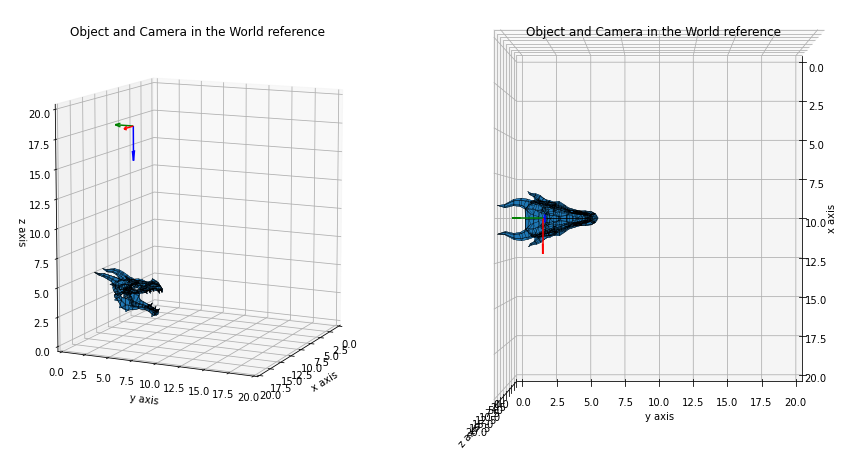

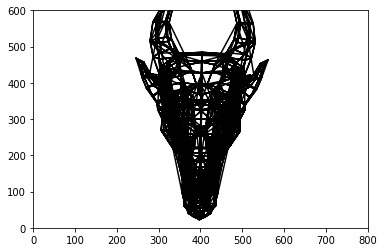

In [39]:

#@markdown Object Translation:
obj_enable_translation = 0 #@param {type:"slider", min:0, max:1, step:1}
obj_dx = 0 #@param {type:"slider", min:-10, max:10, step:1}
obj_dy = 0 #@param {type:"slider", min:-10, max:10, step:1}
obj_dz = 0 #@param {type:"slider", min:-10, max:10, step:1}

print('point_cam: ')
print(point_cam)
point_cam = np.around(point_cam, decimals=1)


# Object TRANSLATION from the created point to the desired point resulting from the translation vector
translation_matrix = translation(obj_enable_translation * obj_dx,
                                 obj_enable_translation * obj_dy,
                                 obj_enable_translation * obj_dz)


points = np.dot((translation_matrix), points)

translation_vector = [obj_enable_translation * obj_dx,
                      obj_enable_translation * obj_dy,
                      obj_enable_translation * obj_dz]

if obj_enable_translation:
    print('Points translate by ',translation_vector,' using translation function.')
    print("translation_matrix")
    print(translation_matrix)
else:
    print('No translation applied to points.')


# Object TRANSLATION from the translated point to the Origin
center_x = np.mean(points[0,:])
center_y = np.mean(points[1,:])
center_z = np.mean(points[2,:])
points = np.dot(translation(-center_x,-center_y,-center_z), points)


#@markdown Object Rotation (World Reference Coordinates):
obj_rotation_order = "NO ROTATION" #@param ["NO ROTATION", "X", "Y", "Z", "X Y", "X Z", "Y X", "Y Z", "Z X", "Z Y", "X Y Z", "X Z Y", "Y X Z", "Y Z X", "Z X Y", "Z Y X"]
obj_angle_degree_x = 0 #@param {type:"slider", min:-180, max:180, step:5}
obj_angle_degree_y = 0 #@param {type:"slider", min:-180, max:180, step:5}
obj_angle_degree_z = 0 #@param {type:"slider", min:-180, max:180, step:5}

# Axes Rotation Order Selection for the Object
rotation_matrix = rotation_selection (obj_rotation_order,
                                      radians(obj_angle_degree_x),
                                      radians(obj_angle_degree_y),
                                      radians(obj_angle_degree_z))

# Object ROTATION at the Origin
points = np.dot(rotation_matrix, points)

# Object TRANSLATION at Origin to translated point
points = np.dot(translation(center_x, center_y, center_z), points)

############

#@markdown Camera Translation:
cam_enable_translation = 0 #@param {type:"slider", min:0, max:1, step:1}
cam_dx = 0 #@param {type:"slider", min:-10, max:10, step:0.1}
cam_dy = 0 #@param {type:"slider", min:-10, max:10, step:0.1}
cam_dz = 0 #@param {type:"slider", min:-10, max:10, step:0.1}


# Camera TRANSLATION from the created point to the desired point resulting from the translation vector
point_cam = np.dot(translation(cam_enable_translation * cam_dx,
                               cam_enable_translation * cam_dy,
                               cam_enable_translation * cam_dz), point_cam)


#@markdown Camera Rotation (World Reference Coordinates):
cam_rotation_order = "NO ROTATION" #@param ["NO ROTATION", "X","Y","Z","X Y","X Z","Y X","Y Z","Z X","Z Y","X Y Z", "X Z Y", "Y X Z", "Y Z X", "Z X Y", "Z Y X"]
cam_angle_degree_x = 0 #@param {type:"slider", min:-180, max:180, step:5}
cam_angle_degree_y = 0 #@param {type:"slider", min:-180, max:180, step:5}
cam_angle_degree_z = 0 #@param {type:"slider", min:-180, max:180, step:5}
cam_angle_x = (cam_angle_degree_x)*2*pi/360
cam_angle_y = (cam_angle_degree_y)*2*pi/360
cam_angle_z = (cam_angle_degree_z)*2*pi/360


# Point Coordinates of the camera before translating to the origin
cam_center_x = point_cam[0,3]
cam_center_y = point_cam[1,3]
cam_center_z = point_cam[2,3]


# Select Condition: Object Rotation Axes Order
cam_rotation_matrix = rotation_selection (cam_rotation_order, cam_angle_x, cam_angle_y, cam_angle_z)

# Camera TRANSLATION from the translated point to the Origin
point_cam = np.dot(translation(-cam_center_x, -cam_center_y, -cam_center_z), point_cam)


# Camera ROTATION at Origin
point_cam = np.dot(cam_rotation_matrix, point_cam)
print()
print('cam_rotation_matrix: ')
print(cam_rotation_matrix)

new_base = point_cam
new_base = new_base[0:3,0:3]

new_e1 = new_base[:,0]
new_e2 = new_base[:,1]
new_e3 = new_base[:,2]
new_base = [new_e1, new_e2, new_e3]
print('new_base: ')
print(new_base)
base = np.array(new_base) # Close LOOP to plot arrows on a new base


# Camera TRANSLATION at Origin to translated point
point_cam = np.dot(translation(cam_center_x, cam_center_y, cam_center_z), point_cam)


# To close the object translation LOOP, point_cam = point_cam
point_cam_draw_arrows = [point_cam[0,3], point_cam[1,3], point_cam[2,3]]

# reshape to fix the matrix to plot 3D
points_plot = np.reshape(points[0:3,:].T, (-1,3,3))


# original point
axis = set_plots(lim=[LIMIT_NEG, LIMIT_POS])
axis = draw_arrows(point_cam_draw_arrows, new_base, axis)

# Plot object in axis[0]
axis[0].add_collection3d(art3d.Poly3DCollection(points_plot))
# Plot the contours of the faces of the object
axis[0].add_collection3d(art3d.Line3DCollection(points_plot, colors='k', linewidths=0.2, linestyles='-'))
# set camera view options of a plot
axis[0].view_init(elev=10,azim=25)
axis[0].dist = 10


# Plot object in axis[1]
axis[1].add_collection3d(art3d.Poly3DCollection(points_plot))
# Plot the contours of the faces of the object
axis[1].add_collection3d(art3d.Line3DCollection(points_plot, colors='k', linewidths=0.2, linestyles='-'))
# set camera view options of a plot
axis[1].view_init(elev=90, azim=0) # Vista Superior
# axis[1].view_init(elev=0, azim=90) # Vista da Projeção
axis[1].dist = 7


# Create the inverse of rotational and translation matrix of the camera as point_cam_inv
point_cam_inv = np.linalg.inv(point_cam)

# Extrinsic matrix is point_cam_projection
point_cam_projection = np.dot(point_cam_inv,points)

# Create projection matrix as pi_matrix
pi_matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

# Projection
point_cam_projection = np.dot(pi_matrix,point_cam_projection)


#@markdown Camera Intrinsic Parameters:
lens_type = "Variable Zoom Lens" #@param ["Fixed Focal Length Lens", "Variable Zoom Lens", "Specific Focus Length"]
lens_size = "Standard 50mm" #@param ["Ultra Wide Angle 12mm", "Ultra Wide Angle 18mm", "Wide Angle 24mm", "Standard 35mm", "Standard 50mm", "Standard 55mm", "Standard 70mm", "Mild Telephoto 70mm", "Mild Telephoto 85mm", "Mild Telephoto 105mm", "Telephoto 135mm", "Telephoto 200mm", "Telephoto 300mm", "Super telephoto +300mm"]
lens_zoom = 2 #@param {type:"slider", min:1, max:3, step:0.01}
lens_focus_f_mm = 300 #@param {type:"number"}

if lens_type == "Specific Focus Length":
    lens_focus_f_mm == lens_focus_f_mm
elif lens_type == "Fixed Focal Length Lens" or "Variable Zoom Lens":
    if lens_size == "Ultra Wide Angle 12mm":
        lens_focus_f_mm = 12
    elif lens_size == "Ultra Wide Angle 18mm":
        lens_focus_f_mm = 18
    elif lens_size == "Wide Angle 24mm":
        lens_focus_f_mm = 24
    elif lens_size == "Standard 35mm":
        lens_focus_f_mm = 35
    elif lens_size == "Standard 50mm":
        lens_focus_f_mm = 50
    elif lens_size == "Standard 55mm":
        lens_focus_f_mm = 55
    elif lens_size == "Standard 70mm":
        lens_focus_f_mm = 70
    elif lens_size == "Mild Telephoto 70mm":
        lens_focus_f_mm = 70
    elif lens_size == "Mild Telephoto 85mm":
        lens_focus_f_mm = 85
    elif lens_size == "Mild Telephoto 105mm":
        lens_focus_f_mm = 105
    elif lens_size == "Telephoto 135mm":
        lens_focus_f_mm = 135
    elif lens_size == "Telephoto 200mm":
        lens_focus_f_mm = 200
    elif lens_size =="Telephoto 300mm":
        lens_focus_f_mm = 300
    elif lens_size == "Super telephoto +300mm":
        lens_focus_f_mm = 300
    print("Lens with non-standard focus, 300mm focal length selected")

print('')
if lens_type == "Fixed Focal Length Lens":
    print('The type of camera lens is',lens_type,'with',lens_size,'of focus.')
elif lens_type == "Variable Zoom Lens":
#  lens_focus_f_mm = lens_focus_f_mm * (1+(lens_zoom/100))
    lens_focus_f_mm = lens_focus_f_mm * lens_zoom
    print('The type of camera lens is',lens_type,'with',lens_size,'of focus and Zoom of X',lens_zoom)
elif lens_type == "Specific Focus Length":
    print('The type of camera lens is a',lens_type,'with',lens_focus_f_mm,'mm')


ccd_model = "800x600 (SVGA)" #@param ["640x480 (VGA)", "800x600 (SVGA)", "1024x768 (XGA)", "1920x1080 (FHD)", "3840x2160 (4K UHD)"]
ccd_dict = {
    "640x480 (VGA)":{'size':{'x':640, 'y':480}, 'scale_factor':{'sx':10, 'sy':10}},
    "800x600 (SVGA)":{'size':{'x':800, 'y':600}, 'scale_factor':{'sx':12.5, 'sy':12.5}},
    "1024x768 (XGA)":{'size':{'x':1024, 'y':768}, 'scale_factor':{'sx':16, 'sy':16}},
    "1920x1080 (FHD)":{'size':{'x':1920, 'y':1080}, 'scale_factor':{'sx':26, 'sy':26}},
    "3840x2160 (4K UHD)":{'size':{'x':3840, 'y':2160}, 'scale_factor':{'sx':52, 'sy':52}}
}
ccd_size_x = ccd_dict[ccd_model]['size']['x']
ccd_size_y = ccd_dict[ccd_model]['size']['y']
scale_factor_sx = ccd_dict[ccd_model]['scale_factor']['sx']
scale_factor_sy = ccd_dict[ccd_model]['scale_factor']['sy']

print('ccd_model:',ccd_model,' | Ox:',ccd_size_x/2,' | Oy:',ccd_size_y/2,' | Sx:',scale_factor_sx,' | Sy:',scale_factor_sy)
print()


# Create intrinsinc matrix as intrinsic_matrix
'''
[[f_mm * scale_factor_sx,      0                , ccd_size_x/2],
 [     0                , f_mm * scale_factor_sy, ccd_size_y/2],
 [     0                ,      0                ,      1      ]]
'''
intrinsic_matrix = np.array([[lens_focus_f_mm * scale_factor_sx, 0, ccd_size_x/2], [0, lens_focus_f_mm * scale_factor_sy, ccd_size_y/2], [0, 0, 1]])
print('intrinsic_matrix: ')
print(intrinsic_matrix)

# Projection
point_cam_projection = np.dot(intrinsic_matrix,point_cam_projection)

# Projection
point_cam_projection = np.divide(point_cam_projection,point_cam_projection[2,:])

# Plot of the projection of the object seen by the camera
figura = plt.figure()
axt = plt.axes()
axt.set_xlim([0, ccd_size_x])
axt.set_ylim([ccd_size_y, 0])
axt.plot(point_cam_projection[0,:], point_cam_projection[1,:], 'k')
plt.show()
